# [Projet 6: Catégorisez automatiquement des questions](https://openclassrooms.com/fr/projects/categorisez-automatiquement-des-questions)
(parcours data: [here](https://openclassrooms.com/paths/63-data-scientist))

Data exporter (StackExchange): [here](https://data.stackexchange.com/stackoverflow/query/new).  
My minimal SQL query:
```
SELECT
   Id,Body,Title,Tags
FROM
   Posts
WHERE
   Id < 5000 and Body<>'' and Title<>'' and Tags <>''
```

Resources:
- [tutorial on kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words) (I did this basically on my own, but look at the features with scikit-learn section)

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(HOME+'Documents/GitHub/OCDataSciencePath/Project6/Work/')    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import pandas as pd
from scipy.sparse import hstack

import matplotlib.pyplot as plt
%matplotlib inline

Some info and uses for [BeautifulSoup](https://pypi.org/project/beautifulsoup4/): [here](https://www.pythonforbeginners.com/beautifulsoup/beautifulsoup-4-python),

In [2]:
from bs4 import BeautifulSoup # conda install beautifulsoup4

Some info and uses for [NLTK](https://pypi.org/project/nltk/): [here](http://www.nltk.org/book/),

In [3]:
import nltk
#nltk.download('punkt')

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [5]:
from Pkg.helper import basicHTMLTextCleaner, basicTagTextCleaner # needs correct working directory

### Data

In [6]:
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = HOME+'Documents/Dropbox/Transit/OCDataScienceData/Project6/'    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))

In [7]:
filename = 'QueryResults_light.csv'
filename = 'QueryResults_10k.csv'

df = pd.read_csv(pathToDataDir+filename,index_col='Id')

In [8]:
n,p = df.shape
k = .8
df_train,df_test = df.iloc[:int(k*n),:].copy(),df.iloc[int(k*n):,:].copy()

In [9]:
print(df_train.shape,df_test.shape)
df_train.sample(5)

(788, 3) (198, 3)


,Body,Title,Tags
Id,,,
6326,<p>I have the following html.erb code that I'm...,Haml: how do I set a dynamic class value?,<css><ruby-on-rails><haml>
3136,<p>How can I set up my crontab to execute X sc...,How to setup a crontab to execute at specific ...,<cron><settings>
2550,<p>A quick glance at the present-day internet ...,What are effective options for embedding video...,<asp.net><flash><video><embed>
7592,<p>I want to create a client side mail creator...,Can I use JavaScript to create a client side e...,<javascript><email>
650,<p>I would like the version property of my app...,Automatically update version number,<c#><visual-studio><versioning>


### Basic text cleaning

In [10]:
def applyCleaner(df,tokenizer,stopwords,stemer):
    '''
    applies the cleaner to a pd.DataFrame. See called functions for help.
    '''
    for c in ('Body','Title'):
        df[c+'_clean'] = df[c].apply(lambda x: basicHTMLTextCleaner(x,tokenizer,stopwords,stemer))
    for c in ('Tags',):
        df[c+'_clean'] = df[c].apply(lambda x: basicTagTextCleaner(x))
        
    return df

In [11]:
stopwords = set(nltk.corpus.stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemer = nltk.PorterStemmer()

df_train = applyCleaner(df_train,tokenizer,stopwords,stemer)
df_test = applyCleaner(df_test,tokenizer,stopwords,stemer)

In [12]:
df_train.sample(50)

,Body,Title,Tags,Body_clean,Title_clean,Tags_clean
Id,,,,,,
810,<p>I'm trying to maintain a Setup Project in <...,Visual Studio Setup Project - Per User Registr...,<windows><visual-studio><registry><installation>,tri maintain setup project visual studio 2003 ...,visual studio setup project per user registri set,<windows><visual-studio><registry><installation>
1408,"<p>Is it possible to configure <a href=""http:/...",Make XAMPP/Apache serve file outside of htdocs,<php><apache><xampp><server-configuration>,possibl configur xampp serv file outsid htdoc ...,make xampp apach serv file outsid htdoc,<php><apache><xampp><server-configuration>
564,"<p>I was reading <em><a href=""http://rads.stac...",What is the difference between an int and an I...,<c#><java><integer><int>,read joel softwar came across joel spolski say...,differ int integ java c,<c#><java><integer><int>
5084,"<p>Today, I ran into this weird problem with a...",Upload form does not work in Firefox 3 with Ma...,<macos><firefox><upload>,today ran weird problem user use mac os x user...,upload form work firefox 3 mac os x,<macos><firefox><upload>
6703,<p>Since I started studying object-oriented pr...,When is OOP better suited for?,<oop>,sinc start studi object orient program frequen...,oop better suit,<oop>
7990,<p>I am working on a project right now that in...,Printing from a .NET Service,<c#><.net><windows-services><printing>,work project right involv receiv messag anoth ...,print net servic,<c#><.net><windows-services><printing>
4416,<p>I am walking through the MS Press Windows W...,"Where can I get the Windows Workflow ""wca.exe""...",<.net-3.5>,walk ms press window workflow step step book c...,get window workflow wca exe applic,<.net-3.5>
1376,<p>I need the name of the current logged in us...,Get the current logged in OS user in Adobe Air,<flex><air>,need name current log user air flex applic app...,get current log os user adob air,<flex><air>
7074,<p>Example (<em>note the case</em>):</p>\n\n<p...,What is the difference between String and stri...,<c#><.net><string><types><alias>,exampl note case string hello world string hel...,differ string string c,<c#><.net><string><types><alias>


### Vectorization

Resources
- [scikit tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) (also used in this [kaggle example](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words))

*Input texts:*

In [13]:
# count occurences (beware to fit the dictionary only on train data!)
# NB: deal with tags separately, as they basically need one-hot encoding
V_body = 20 # 500
count_body = CountVectorizer(analyzer = "word",   # entities to be counted
                             preprocessor = None, # because we did it ourselves
                             lowercase = False,   # because we did it ourselves
                             stop_words = None,   # because we did it ourselves
                             tokenizer = None,    # because we did it ourselves
                             max_features = V_body) 

count_body.fit(df_train['Body_clean'])
vocab_body = count_body.vocabulary_

V_title = 5 # 100
count_title = CountVectorizer(analyzer = "word",   # entities to be counted
                              preprocessor = None, # because we did it ourselves
                              lowercase = False,   # because we did it ourselves
                              stop_words = None,   # because we did it ourselves
                              tokenizer = None,    # because we did it ourselves
                              max_features = V_title) 

count_title.fit(df_train['Title_clean'])
vocab_title = count_title.vocabulary_

# transform to vectors using the fitted dictionaries
body_train = count_body.transform(df_train['Body_clean'])
title_train = count_title.transform(df_train['Title_clean'])

body_test = count_body.transform(df_test['Body_clean'])
title_test = count_title.transform(df_test['Title_clean'])

In [14]:
# use TF-IDF (beware to fit the IDF with train data!)
tfidf_body = TfidfTransformer(use_idf=True).fit(body_train)
tfidf_title = TfidfTransformer(use_idf=True).fit(title_train)

# transform using the fitted IDF
body2_train = tfidf_body.transform(body_train)
title2_train = tfidf_title.transform(title_train)

body2_test = tfidf_body.transform(body_test)
title2_test = tfidf_title.transform(title_test)

In [15]:
body2_train[0,:].toarray()

array([[ 0.31318545,  0.56187979,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.28963071,  0.        ,  0.        ,
         0.        ,  0.        ,  0.29191905,  0.34098898,  0.        ,
         0.26910511,  0.        ,  0.        ,  0.47792494,  0.        ]])

In [16]:
title2_train[0,:].toarray()

array([[ 0.,  0.,  0.,  0.,  0.]])

*Target tags:*

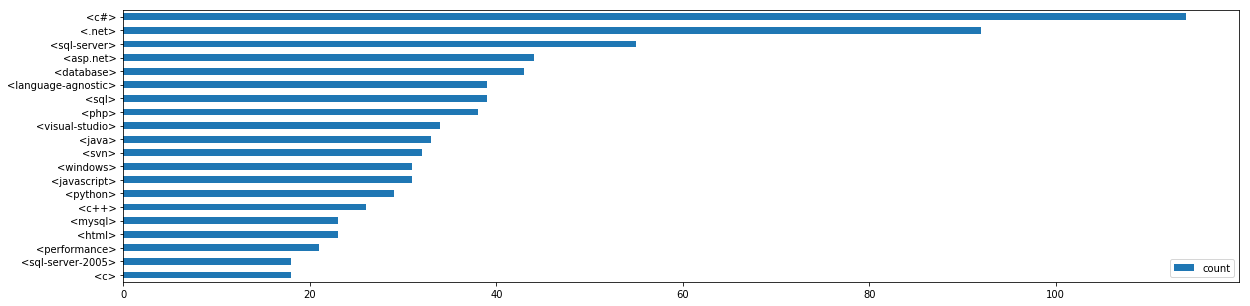

In [17]:
# analysis of the tags (NB: here we only 'multiplly'-one-hot encode: there is no need to compute TF-IDF!)

# count occurences
V_tag = 20 # NB (after viewing the plots): a looot of tags appear only once
count_tag = CountVectorizer(analyzer = "word",   # entities to be counted
                            preprocessor = None, # because we did it ourselves
                            lowercase = False,   # because we did it ourselves
                            stop_words = None,   # because we did it ourselves
                            tokenizer = None,    # because we did it ourselves
                            token_pattern = '<[^[<>]*>', # otherwise, treats tags as words
                            max_features = V_tag) 

count_tag.fit(df_train['Tags_clean'])
vocab_tag = count_tag.vocabulary_

# transform
tag_train = count_tag.transform(df_train['Tags_clean'])
tag_test = count_tag.transform(df_test['Tags_clean'])

# plot number of questions per tag
tagCount = pd.DataFrame(index=['count'])
for t,i in vocab_tag.items():
    tagCount[t] = tag_train[:,i].sum()
tagCount = tagCount.transpose()
tagCount = tagCount.sort_values(by='count',ascending=True)
tagCount.plot(kind='barh',figsize=(20,5))

In [18]:
tag_train[0,:].toarray()

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

*Merge together:*

In [19]:
x_train = hstack((body2_train,title2_train)) # need hstack because we work on sparse matrices...
x_test = hstack((body2_test,title2_test))

y_train = tag_train
y_test = tag_test

*NEXT: handle cases when some rows do not have selected words/tags...*

### Cleaned data

In [20]:
name,ext = os.path.splitext(filename)

#c = ('Body_clean','Title_clean','Tags_clean')
#df.loc[:,c].to_csv(os.path.join(pathToDataDir,name+'_clean'+ext),index=True)

np.savez(os.path.join(pathToDataDir,name+'_forLearning'), *[x_train,x_test,y_train,y_test])